# TUnfoldDensity with Coffea histograms


In [1]:
import ROOT
import numpy as np
import array as array
import math
import uproot
import pickle as pkl
#import statistics as st
ROOT.gStyle.SetOptStat(000000)

Welcome to JupyROOT 6.30/04


## Construct the Binning scheme

Set the axis ranges for the generator (m bins) and detector  (n bins) level distributions as well as the number of bins in each. *Note* that we are currently using twice as many detector bins as generator level bins as recommended by the TUnfold documenation. This condition $n ≥ m$ 
is in contrast to many common unfoldding algorithms which require $n = m$ however a notable example of an unfolding algorithm without that restriction is __[G. D’Agostini](arXiv:1010.0632)__.

In [2]:
### Set up the binning scheme
mbinsGen  = array.array('d',  [0,2.5,5,7.5,10,15,20,30,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,1000])
mbinsDet  = array.array('d', [0,5,10,20,40,60,80,100,150,200,250,300,350,1000])
ptbinsGen = array.array('d', [200,260,350,460,550,650,760,13000])
ptbinsDet = array.array('d', [200,260,350,460,550,650,760,13000])

#mbinsGen  = array.array('d', [0., 25.,50.,75.,100. ])# [0., 50., 100. ])
#mbinsDet  = array.array('d', [0., 12.5, 25.,37.5,50., 62.5,75., 87.5, 100. ])#[0., 25.,50.,75.,100. ])
#ptbinsGen = array.array('d', [0., 25.,50.,75.,100. ])#[0., 50., 100. ])
#ptbinsDet = array.array('d', [0., 25.,50.,75.,100. ])#[0., 50., 100. ])


nmbinsGen  = len(mbinsGen) -1
nmbinsDet  = len(mbinsDet) -1
nptbinsGen = len(ptbinsGen) -1
nptbinsDet = len(ptbinsDet) -1

#print "There are {} Gen Mass bins , {} Gen Pt bins ,{} Reco Mass bins , {} Reco Pt bins  ".format(nmbinsGen,nptbinsGen , nmbinsDet,nptbinsDet)

Instantiate the TUnfoldBinning Scheme. The "signal" node represents the generator level (coarser) binning whereas the "detector" node represents the (finer) input binning scheme. 

In [3]:
generatorBinning = ROOT.TUnfoldBinning("generator")
### Need coarser binning for signal
signalBinning = generatorBinning.AddBinning("signal")    
signalBinning.AddAxis("massgen",nmbinsGen,mbinsGen,
                        False, # needed for fakes
                        False # overflow bin
                        )
signalBinning.AddAxis("ptgen",nptbinsGen,ptbinsGen,
                        False, # needed for fakes
                        False # overflow bin
                        )

# X axis : generator binning is Signal : mgen * ptgen and Background : mrec * ptrec

xaxis =  array.array('d',[a for a in range(nmbinsGen *nptbinsGen + 1 )])
nx = len(xaxis)-1

# print xaxis
# print "There are {} (signal) generator level bins in the simple scheme".format(nx)
# print "---------------------------------------------------------------"

# print "signalBinning"
#for i in xrange(len(signalBinning.GetDistributionBinning(0))):
    #print  signalBinning.GetDistributionBinning(0)[i]

#print "detectorBinning"
#for i in xrange(len(backgroundBinning.GetDistributionBinning(0))):
#    print backgroundBinning.GetDistributionBinning(0)[i]
    
#print "Below counts include overflow and underflow bins"    
#print "There are {} signal {} background bins in the generator scheme".format(signalBinning.GetTH1xNumberOfBins() , backgroundBinning.GetDistributionNumberOfBins())
genBin = generatorBinning

In [4]:
detectorBinning = ROOT.TUnfoldBinning("detector") 
detectorDistribution=detectorBinning.AddBinning("detectordistribution")
detectorDistribution.AddAxis("mass",nmbinsDet,mbinsDet,
                        False, # no underflow bin (not reconstructed)
                        False # overflow bin
                        )
detectorDistribution.AddAxis("pt",nptbinsDet,ptbinsDet,
                        False, # no underflow bin (not reconstructed)
                        False # overflow bin
                        )

yaxis =  array.array('d',[a for a in range(nmbinsDet *nptbinsDet+1 )])
ny = len(yaxis)-1

# print yaxis
print ("There are {}  detector level bins in the simple scheme".format(ny))
# print "detectorBinning"
# for i in xrange(len(detectorDistribution.GetDistributionBinning(0))):
#     print detectorDistribution.GetDistributionBinning(0)[i]
    
print ("Below counts include overflow and underflow bins" ) 
print("There are {} bins in the detector scheme".format(detectorDistribution.GetTH1xNumberOfBins()))#GetDistributionNumberOfBins())
detBin  = detectorBinning

There are 91  detector level bins in the simple scheme
Below counts include overflow and underflow bins
There are 91 bins in the detector scheme


# Create Response Matrix and 1D input 

In [5]:


M = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M")
M1 = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M+1#sigma")
M2 = ROOT.TUnfoldBinning.CreateHistogramOfMigrations(generatorBinning,detectorBinning,"M-1#sigma")

h = detectorBinning.CreateHistogram("h")

hup = detectorBinning.CreateHistogram("hup")
hdn = detectorBinning.CreateHistogram("hdn")



htrue = generatorBinning.CreateHistogram("htrue")
htruef = detectorBinning.CreateHistogram("htruef")



## Generate the response matrix

Here, we have a respone matrix with 4 coarse and 8 fine bins (configurable). The variable of interest ($x$) ranges from 0 to 100. We assume the resolution on $x$ is 1.0, and that there is a systematic uncertainty "scale", which has an "up" and "down" variation of 2%. We generate 10000 pseudo-events for each value of x between 0 and 100, smeared by the resolution. For each of the "x" values, a reconstructed "y" value is constructed, again smeared by the resolution. We then add the "up" and "down" scale uncertainites. Finally, we construct TH2 matrices that represent the response matrices. 

In [6]:
with open("qjetmass_zjets_gen.pkl", "rb") as f:
    output = pkl.load( f )

In [7]:
M_np = output['response_matrix_g'].project("ptgen","mgen","ptreco","mreco").values(flow = False)

M_np = M_np.reshape( M_np.shape[0]*M_np.shape[1],M_np.shape[2]*M_np.shape[3] )

h_np = np.sum(output['response_matrix_g'].project("ptgen","mgen","ptreco","mreco").values(flow = False), (0,1)).reshape(91)
htrue_np = np.sum(output['response_matrix_g'].project("ptgen","mgen","ptreco","mreco").values(flow = False), (2,3)).reshape(175)

In [8]:




for i in range(M_np.shape[0]):
    for j in range(M_np.shape[1]):
        M.SetBinContent(i+1, j+1, M_np[i][j])
        M1.SetBinContent(i+1, j+1, M_np[i][j]*(1+np.random.random()))
        M2.SetBinContent(i+1, j+1, M_np[i][j]*(1-np.random.random()))
   

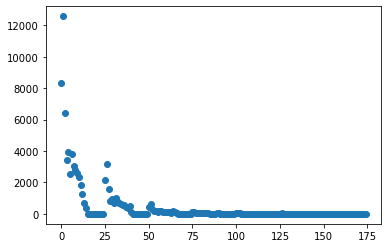

In [9]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(htrue_np)),htrue_np)

In [10]:
M.Integral()

75731.43193571127

In [11]:
M_np.shape

(175, 91)

In [12]:
htrue.GetNbinsX()

175

In [13]:
#M.Integral()
np.sum(htrue_np)

75731.43193571133

In [23]:
for i in range(91):
    h.SetBinContent(i+1,h_np[i])
    
for j in range(175):
    htrue.SetBinContent(j+1, htrue_np[j])

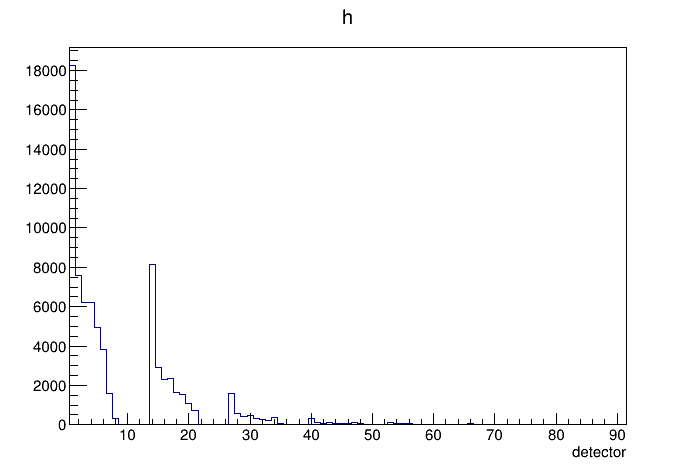

In [24]:
can = ROOT.TCanvas()
h.Draw()
can.Draw()

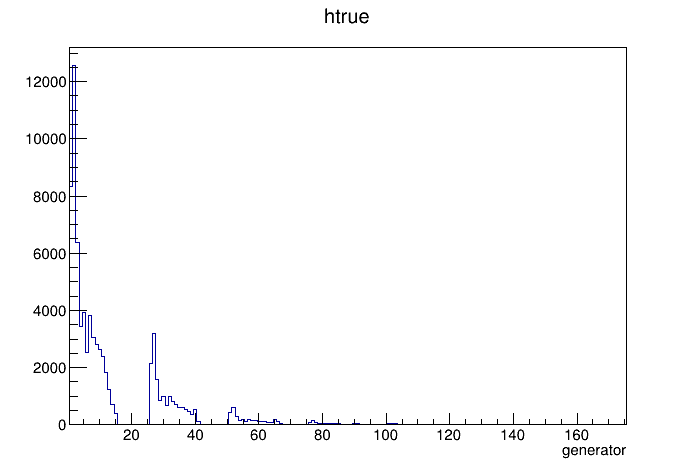

In [25]:
can = ROOT.TCanvas()
htrue.Draw()
can.Draw()

In [26]:
'''
for bx in xrange(M.GetNbinsX()):
    for by in xrange(M.GetNbinsY()):
        bc = M.GetBinContent(bx,by)
        if bc > 1. :
            gxn = signalBinning.GetBinName(bx)
            gyn = detectorDistribution.GetBinName(by)
            print "Bin X {} {} Y {} {} is filled with {} ".format(bx, gxn, by, gyn, bc)
'''            

'\nfor bx in xrange(M.GetNbinsX()):\n    for by in xrange(M.GetNbinsY()):\n        bc = M.GetBinContent(bx,by)\n        if bc > 1. :\n            gxn = signalBinning.GetBinName(bx)\n            gyn = detectorDistribution.GetBinName(by)\n            print "Bin X {} {} Y {} {} is filled with {} ".format(bx, gxn, by, gyn, bc)\n'

# Normalize by Pt (y) bin

In [27]:
normalize = False

In [28]:
ptbinsgenglobal = [ [0,5] ,[6,8], [10,12] , [13,13]  ]

ptbinsdetglobal = [  [0,0] , [1,5] , [6,10] , [11,15] ]#, [16,18 ]  ]


In [29]:

def NormM(rMMx = None  , recoorgen2 = None,  nameg = None) :

    ### Make a new empty TH2 so the OFL and UFL will be zero
    rMMnx = rMMx.Clone(nameg)
    for xx in range(rMMnx.GetNbinsX()+1) :
        for yy in range(rMMnx.GetNbinsY()+1) :
            rMMnx.SetBinContent(xx , yy ,0.0) 
            rMMnx.SetBinError(xx , yy ,0.0)   
        
    
    intscales3 = [ ]
    intsums = [ ]
    intsums2 = [ ]
    bins1 = [ ]
    bins2 = [ ]

    #if intscalesin == None :
    ptbs1 = None
    ptbs2 = None    
    if recoorgen2 == 'reco':  
        ptbs1 = ptbinsdetglobal
        ptbs2 = ptbinsgenglobal 
        bins1 = detBin
        noden1 = "detectordistribution"
        bins2 = genBin
        noden2 = "signal"
    elif recoorgen2 == 'gen':  
        ptbs1 = ptbinsgenglobal
        ptbs2 = ptbinsdetglobal 
        bins1 = genBin
        noden1 = "signal"
        bins2 = detBin
        noden2 = "detectordistribution"
        
    for iptb,ptbg in enumerate(ptbs1[1:-1]) :
        sumn = 0
        tint = 0.
        #print ptbinsGen[iptb]
        #print ptbinsGen[iptb+1]
        #ptw = ptbinsGen[iptb+1] - ptbinsGen[iptb]
        #print "New Pt bin {}- {} GeV of width {} GeV".format(ptbinsGen[iptb] , ptbinsGen[iptb+1] , ptw )
        for iy in range( ptbg[0], ptbg[1]): #  
            
            db = bins1.FindNode(noden1).GetBinName(iy)
            #print db
            dbs = bins1.FindNode(noden1).GetBinSize(iy)
            tgbs = dbs #1.     
            bw = 1.
            #print ptw
            #if ptw > 0.:
            #    tgbs = gbs/ptw
            #print    tgbs 
            for iptbr,ptbr in enumerate(ptbs2[1:-1]) :
                for ix in range(ptbr[0],ptbr[1]):
                    #print ptbr[0]
                    #print "to"
                    #print ptbr[1]
                    gb = bins2.FindNode(noden2).GetBinName(ix)
                    #db = detBin.FindNode("detectordistribution").GetBinName(ix)
                    #if 'mass[ofl]' in str(db): 
                    #print "...."+str(gb)
                    #    continue
                    gbs = bins2.FindNode(noden2).GetBinSize(ix)
                    
                    #if iy ==1:print dbs
                    #tdbs = dbs#/ptw
                    #print tdbs
                    bw = gbs*dbs

                    rbc = rMMx.GetBinContent(ix , iy)
                    trbc = rMMx.GetBinContent(ix , iy)
                    #print trbc

                    rbe = rMMx.GetBinError(ix , iy)
                    trbe = rMMx.GetBinError(ix , iy)
                    #print bw
                    if bw > 0. :
                        trbc = rbc/bw
                        trbe = rbe/bw               
                    rMMnx.SetBinContent(ix, iy , trbc)    
                    rMMnx.SetBinError(ix, iy , trbe)  
                    tint+=trbc
                    sumn+=1
        #print "Integral of bin {} {} is {} and it was the sum of {} bins".format(ptbg, iptb, tint, sumn)        
        intscales3.append(tint)
        intsums.append(sumn)
    #print "Integral of bin x :"
    #print intscales3
    #elif intscalesin != None :
    #    intscales = tint #intscalesin
    #print "scaling by {}".format(tint)
    for iptb,ptbg in enumerate(ptbs1[1:-1]) :
        sumn2 = 0
        sdsdx = intscales3[iptb]
        #print sdsdx
        #print ptbg
        #print iptb
        #print "New Pt bin "
        for iy in range( ptbg[0], ptbg[1]): #  
            for iptbr,ptbr in enumerate(ptbs2[1:-1]) :
                for ix in range(ptbr[0],ptbr[1]):

                    rbc = rMMnx.GetBinContent(ix , iy)
                    trbc = rMMnx.GetBinContent(ix , iy)
                    #print trbc

                    rbe = rMMnx.GetBinError(ix , iy)
                    trbe = rMMnx.GetBinError(ix , iy)
                    #print bw
                    if sdsdx > 0. :
                        trbc = rbc/sdsdx
                        trbe = rbe/sdsdx               
                    rMMnx.SetBinContent(ix , iy , trbc)    
                    rMMnx.SetBinError(ix , iy, trbe) 
                    sumn2 +=1
        intsums2.append(sumn2)     
    #print intsums
    #print intsums2    
    return rMMnx #, intscales3 ]



In [30]:
def NormXorY(XorY = None , recorgen = None , nameg = None) :
    ### Make a new empty TH1 so the OFL and UFL will be zero
    XorYn = XorY.Clone()
    for xx in range(XorY.GetNbinsX()+1) :
        XorYn.SetBinContent(xx  ,0.0) 
        XorYn.SetBinError(xx  ,0.0)   
        
    gpts = None
    bins = None
    noden = None

    
    
    if recorgen == 'reco' :
        gpts = ptbinsdetglobal
        bins = detBin
        noden = "detectordistribution"
    elif recorgen == 'gen' :
        gpts = ptbinsgenglobal        
        bins = genBin
        noden = "signal"
    intscalesx = [ ]
    
    for iptbr,ptbr in enumerate(gpts[1:-1]) :
        tint = 0.
        #print iptbr
        #print ptbr        
        #print ptbinsGen[iptbr+1]
        #print ptbinsGen[iptbr]        
        #ptw = ptbinsGen[iptbr+1] - ptbinsGen[iptbr]
        for iy in range(ptbr[0],ptbr[1]):
            #print ptbr[0]
            #print "to"
            #print ptbr[1]
            db = bins.FindNode(noden).GetBinName(iy)
            #if 'mass[ofl]' in str(db): 
            #print db
            #    continue
            dbs = bins.FindNode(noden).GetBinSize(iy)
            #if iy ==1:print dbs
            tdbs = dbs#/ptw
            #if bins == genBin:
            #    tdbs = tdbs * ptw
            bw = tdbs# *ptw

            rbc = XorY.GetBinContent(iy)
            trbc = 0.#XorY.GetBinContent( iy)
            #print trbc

            rbe = XorY.GetBinError( iy)
            trbe = 0.#XorY.GetBinError( iy)
            #print bw
            if bw > 0. :
                trbc = rbc/bw
                trbe = rbe/bw               
            XorYn.SetBinContent(iy , trbc)    
            XorYn.SetBinError(iy , trbe)  
            tint+=trbc
        intscalesx.append(tint)
    #print "Integral of bin x for NormXorY is :"
    #print intscalesx


    for iptb,ptbg in enumerate(gpts[1:-1]) :
        tint = 0.
        sdsd = intscalesx[iptb]
        #print sdsd
        #print ptbg
        #print iptb
        #rint "New Pt bin "
        for ix in range( ptbg[0], ptbg[1]): #  

            rbc = XorYn.GetBinContent(ix)
            trbc = 0.#XorYn.GetBinContent(ix)
            #print trbc

            rbe = XorYn.GetBinError(ix)
            trbe =0. #XorYn.GetBinError(ix)
            #print bw
            if sdsd > 0. :
                trbc = rbc/sdsd
                trbe = rbe/sdsd                
            XorYn.SetBinContent(ix , trbc)    
            XorYn.SetBinError(ix, trbe)  
    return XorYn.Clone(nameg)

               

In [31]:

respN = 'reco'


if normalize :
    M = NormM(M.Clone() , respN,"M_norm") 


In [32]:
if normalize :
    M1 = NormM(M1.Clone() ,respN , "M_Up") 
    M2 = NormM(M2.Clone() , respN,"M_Dn") 

    h = NormXorY(h.Clone() ,'reco', "h_norm") 

    hup = NormXorY(hup.Clone() ,'reco', "hu_norm") 
    hdn = NormXorY(hdn.Clone() ,'reco', "hd_norm") 

    htrue = NormXorY(htrue.Clone() ,'gen', "htrue_norm") 
    htruef = NormXorY(htruef.Clone() ,'reco', "htruef_norm") 


## Draw the response matrix

We draw the nominal and $\pm 1 \sigma$ variations. 

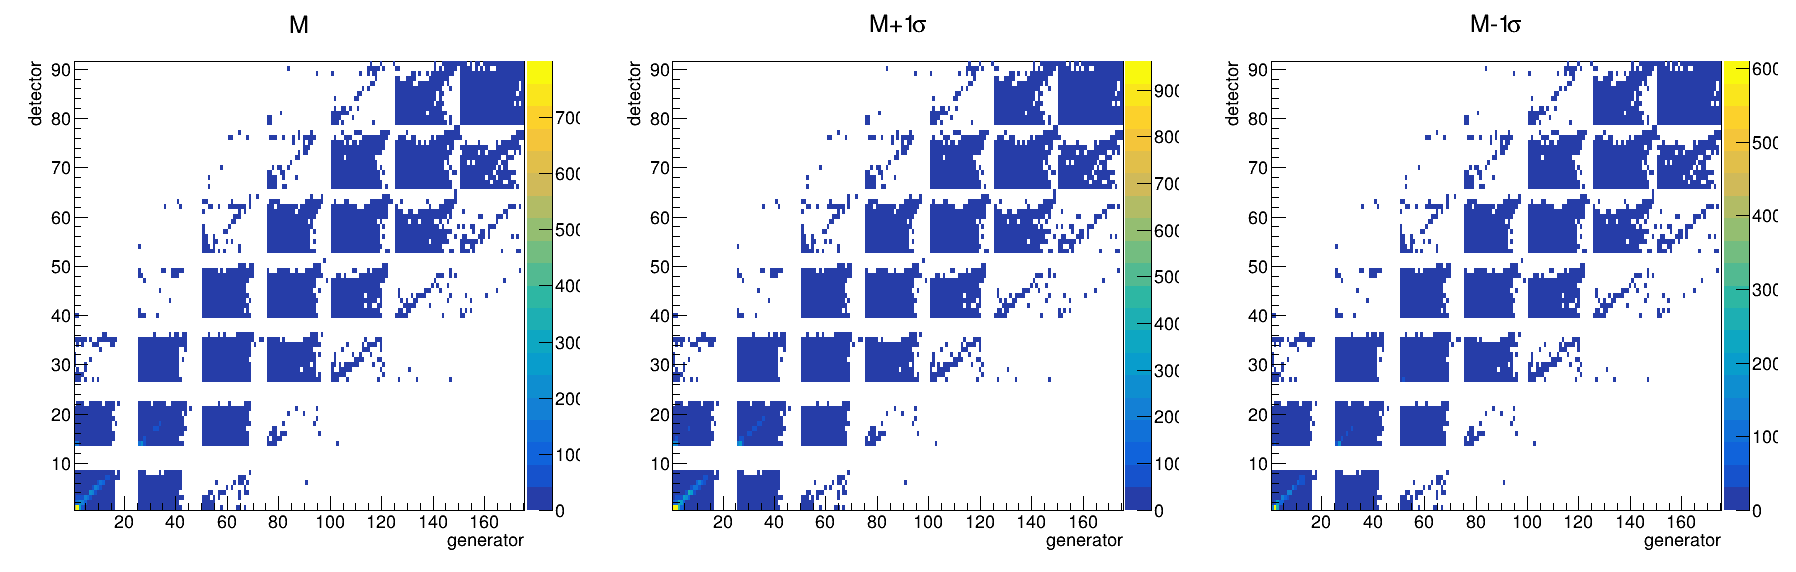

In [33]:

c0 = ROOT.TCanvas("c0", "c0", 1800, 600)
c0.Divide(3,1)
c0.cd(1)
M.Draw("colz")
c0.cd(2)
M1.Draw("colz")
c0.cd(3)
M2.Draw("colz")
c0.Draw()

## Draw the response matrix ratio

We draw the ratio of the $\pm 1 \sigma$ variations to the nominal. 

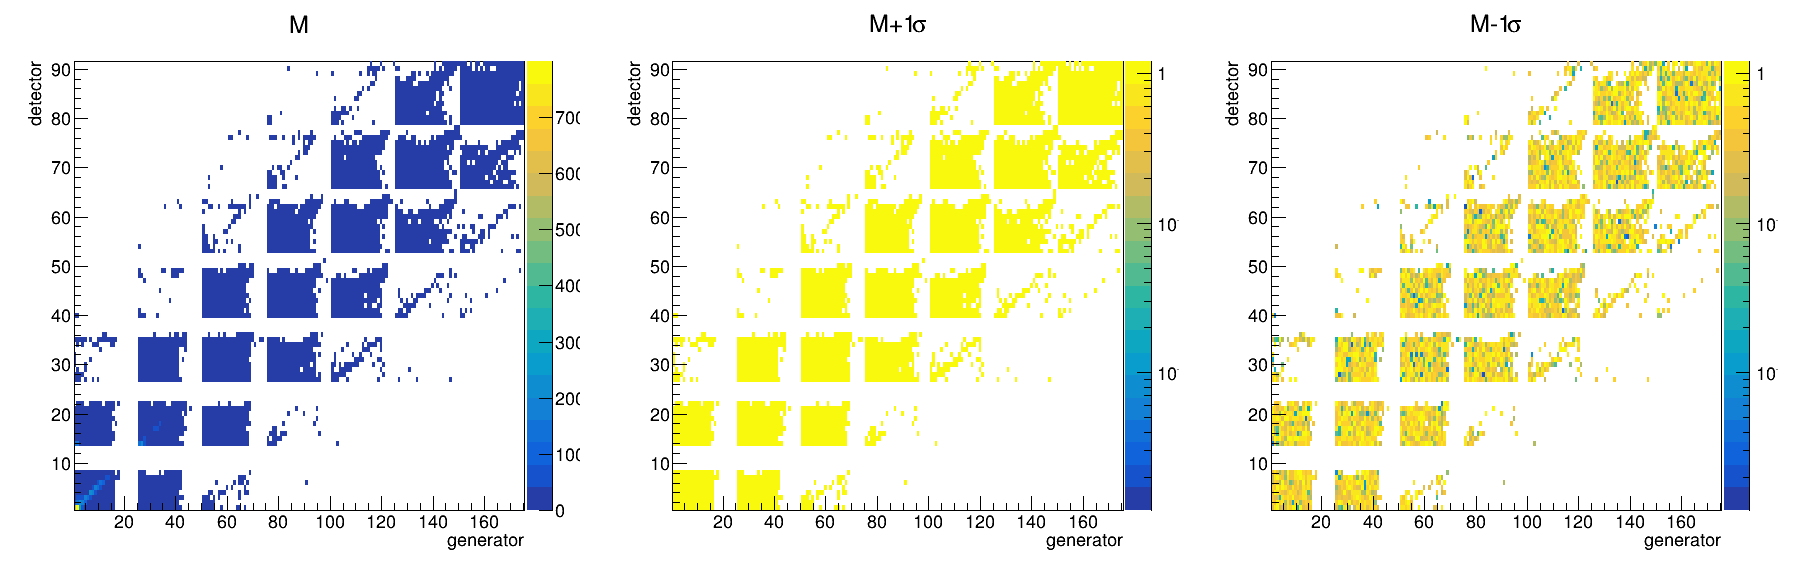

In [34]:
M1ratio = M1.Clone()
M1ratio.Divide(M)
M2ratio = M2.Clone()
M2ratio.Divide(M)
M1ratio.SetMaximum(1.2)
M2ratio.SetMaximum(1.2)

cratio = ROOT.TCanvas("cratio", "cratio", 1800, 600)
cratio.Divide(3,1)
cratio.cd(1)
M.Draw("colz")
cratio.cd(2)
M1ratio.Draw("colz")
ROOT.gPad.SetLogz()
cratio.cd(3)
M2ratio.Draw("colz")
ROOT.gPad.SetLogz()
cratio.Draw()

# Project Response Matrix onto X and Y axis 

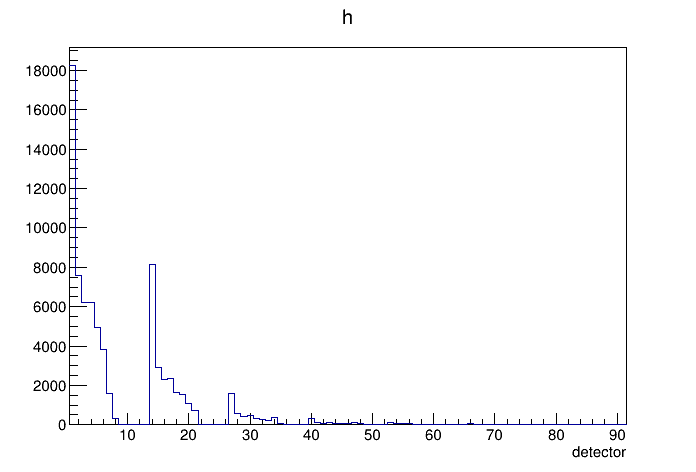

In [37]:
h2 = M.ProjectionY("reco2")
htrue2 = M.ProjectionX("gen2")

c1 = ROOT.TCanvas()
h.SetMarkerStyle(4)
h.SetLineColor(ROOT.kRed)
h.SetLineStyle(2)
h.Draw()
h2.Draw("same")
c1.Draw()


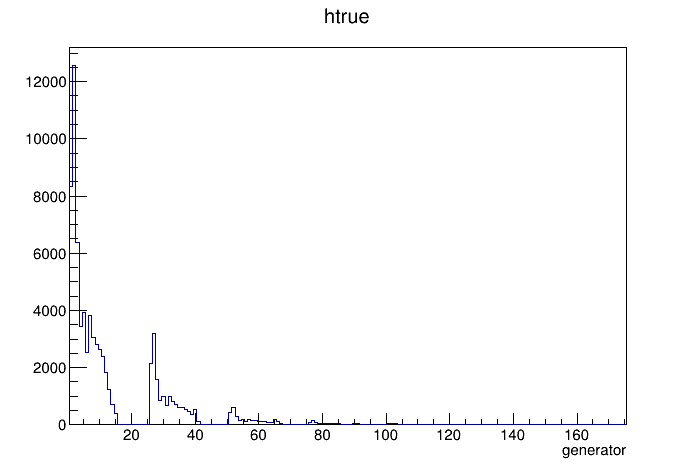

In [38]:
c2 = ROOT.TCanvas()
htrue.SetMarkerStyle(4)
htrue.SetLineColor(ROOT.kRed)
htrue.SetLineStyle(2)
htrue.Draw()
htrue2.Draw("same")
c2.Draw()

## Plot the reconstructed and truth

In [39]:

h2U = M1.ProjectionY("reco2U")
h2D = M2.ProjectionY("reco2D")


## Unfold

1. Create the `TUnfoldDensity` object. 
1. Add the systematic uncertainty variations via `AddSysError`. 
1. Perform the regularization by scanning the L curve. 
1. Get the output. **Note! This does not account for systematic uncertainties automatically. They must be added by hand.**
1. Draw unfolded versus true distributions (in the same coarse binning scheme). 

In [41]:
orientation = ROOT.TUnfold.kHistMapOutputHoriz
regMode = ROOT.TUnfold.kRegModeCurvature
con = ROOT.TUnfold.kEConstraintArea #ROOT.TUnfold.kEConstraintArea
mode =  ROOT.TUnfoldDensity.kDensityModeBinWidth
axisSteering =  "*[b]"

#u = ROOT.TUnfoldDensity(M, orientation, regMode, con, mode, genBin, detBin, "signal", axisSteering)

u = ROOT.TUnfoldDensity(M,orientation,regMode,con)


Info in <TUnfold::SetConstraint>: fConstraint=1
Warning in <TUnfold::TUnfold>: 16 output bins do not depend on the input data  0 19-25 45 47-50 75 100 176
Info in <TUnfold::TUnfold>: 91 input bins and 161 output bins
Error in <TUnfold::TUnfold>: too few (ny=91) input bins for nx=161 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:generator[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #19 (xaxis:generator[18.5,19.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #20 (xaxis:generator[19.5,20.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #21 (xaxis:generator[20.5,21.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #22 (xaxis:generator[21.5,22.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #23 (xaxis:generator[22.5,23.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #24 (xaxis:generator[23.5,24.5])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #25 (xaxis:generator[24.5,25.5])
Info in

In [42]:
u.SetInput( h )


13

Warning in <TUnfoldDensity::SetInput>: 13/91 input bins have zero error, and are ignored.


In [43]:

u.AddSysError(M1, "Up", orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)


In [44]:

u.AddSysError(M2, "Dn", orientation, ROOT.TUnfoldDensity.kSysErrModeMatrix)


In [45]:

u.DoUnfold(0.0)

0.9886888935573553

Error in <TUnfoldDensity::GetInputInverseEmatrix>: number of parameters 161 > 78 (rank of input covariance). Problem can not be solved
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of matrix E 78 expect 161
Info in <TUnfoldDensity::InvertMSparseSymmPos>: cholesky-decomposition failed, try eigenvalue analysis
Warning in <TUnfoldDensity::DoUnfold>: rank of output covariance is 78 expect 161


In [46]:
# Get output... DOES NOT CONTAIN SYSTEMATICS. 
o = u.GetOutput("o")
#o = u.GetOutput("unfolded","","signal", "*[b]", False)
 

In [47]:
# Get systematic shifts of output
o_up = u.GetDeltaSysSource("Up", "o_upshift", "M+1#sigma")
o_dn = u.GetDeltaSysSource("Dn", "o_dnshift", "M-1#sigma")
o_up.SetLineStyle(2)
o_dn.SetLineStyle(2)


In [48]:
# Get various covariances
cov = u.GetEmatrixTotal("cov", "Covariance Matrix")
#cov = u.GetEmatrixTotal("ematrix","Covariance Matrix", "signal", "*[]", False)

cov_uncorr = u.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties")
cov_uncorr_data = u.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data")


#cov_uncorr = u.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties", "signal", "*[]", False)
#cov_uncorr_data = u.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data", "signal", "*[]", False)


In [49]:

# Now prepare various distributions. 
o_unfunc = o.Clone("o_unc")        # Unfolding and stat unc
o_sys = o.Clone("o_sys")        # Syst uncertainty
o_unctot = o.Clone("o_unctot")  # Total uncertainty
o_sys.SetLineStyle(2)


In [50]:

# Create total uncertainty and sys uncertainty plots. 
# Also fix the uncertainties on the output
o_origErrors = o.Clone("o_origErrors")
o_origJustErrors = o.Clone("o_origErrors")

for i in range( 0, o_up.GetNbinsX() + 1):
    unc_tot = ROOT.TMath.Sqrt( cov.GetBinContent(i,i) )
    o_unctot.SetBinContent(i, unc_tot )   
    oe = o.GetBinError(i)
    o_origJustErrors.SetBinContent(i, oe)    
    o.SetBinError(i, unc_tot )
    
    yup = abs( o_up.GetBinContent(i))
    ydn = abs( o_dn.GetBinContent(i))
    dy = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
    o_sys.SetBinContent(i, dy )






In [51]:
#htrue2 = htrue.Clone("h2")
#htrue2.Rebin(finebins/coarsebins)
o.SetMarkerStyle(20)
o.SetMarkerColor(1)
o_origErrors.SetMarkerStyle(21)
o_origErrors.SetMarkerColor(3)
o_unfunc.SetMarkerStyle(0)
o_unfunc.SetLineColor(2)
htrue.SetMarkerStyle(21)
htrue.SetMarkerColor(4)
htrue.SetMarkerStyle(4)
htrue.SetLineColor(4)



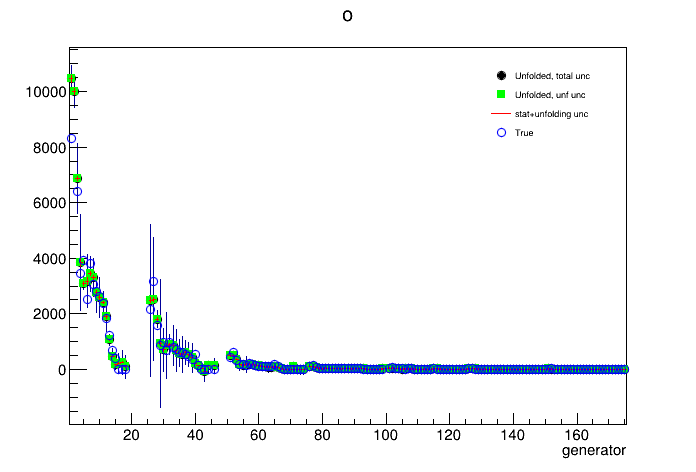

In [52]:
c = ROOT.TCanvas("c","c")
#o.SetMinimum(0.0)
#o.SetMaximum(1.0)

o.Draw()
o_origErrors.Draw("e same")
o_unfunc.Draw("e same")
htrue.Draw("e same")
leg2 = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
leg2.SetBorderSize(0)
leg2.SetFillColor(0)
leg2.AddEntry( o, "Unfolded, total unc",'p')
leg2.AddEntry( o_origErrors, "Unfolded, unf unc",'p')

leg2.AddEntry( o_unfunc, "stat+unfolding unc",'l')
leg2.AddEntry( htrue, "True",'p')
leg2.Draw()
c.Draw()

## Plot closure

The closure plot is the true distribution divided by the unfolded distribution. Aside from the outermost bins, the closure is consistent with unity. 

## Plot the total covariance matrix